# SPARQL Test for Wikidata and DBpedia with LC-QuAD 2.0

In [1]:
# import all the necessary libraries
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
from SPARQLWrapper import SPARQLWrapper, JSON
from collections import Counter

## Get distinct template_ids
Extracting all distinct template_ids from the LC-QuAD 2.0 dataset. This is done to see if all template_ids are covered by the number of test queries/questions. Here it should also be seen if certain queries templates are not working at all, meaning there is not problem with updated information or something, but that the template type is not supported, by either of the endpoints (https://skynet.coypu.org/wikidata/; localhost:8890/sparql). 

In [5]:
# Load the LC-QuAD 2.0 dataset
url = "https://raw.githubusercontent.com/AskNowQA/LC-QuAD2.0/refs/heads/master/dataset/train.json"
response = requests.get(url)
lc_quad_data = response.json()

# Extract distinct template_id values from the full dataset
all_template_ids = {entry.get("template_id") for entry in lc_quad_data if "template_id" in entry}

# Extract distinct template_id values from the first 200 questions
first_200_template_ids = {entry.get("template_id") for entry in lc_quad_data[:200] if "template_id" in entry}

# Check if all distinct template_ids from the full dataset are included in the first 200 questions
missing_template_ids = all_template_ids - first_200_template_ids

# Output the results
print("All template_ids from the full dataset:", all_template_ids)
print("Template_ids in the first 200 questions:", first_200_template_ids)

if not missing_template_ids:
    print("All distinct template_ids are included in the first 200 questions.")
else:
    print(f"The following template_ids are missing in the first 200 questions: {missing_template_ids}")

All template_ids from the full dataset: {'1', 1, 2, 3, '1.1', 5, 'statement_property_2', 'Rank2', 4, 'Count_2', '1.2', 'Rank1', 'Count_1', 'statement_property_1'}
Template_ids in the first 200 questions: {'1', 1, 2, 3, '1.1', 5, 'statement_property_2', 'Rank2', 4, 'Count_2', '1.2', 'Rank1', 'Count_1', 'statement_property_1'}
All distinct template_ids are included in the first 200 questions.


As a result all distinct template_ids are included in the first 200 queries of the LC-QuAD 2.0 dataset.

## Querying Wikidata endpoint
Using the LC-QuAD 2.0 dataset to query the wikidata endpoint (https://skynet.coypu.org/wikidata/). This is done to see if the queries are working and if the endpoint is able to return results. The results should provide answers, those that return "No answer", and queries that fail for some reason (are not properly able to be executed by the endpoint).

In order to achive this the SPARQL queries are executed, sending them to the endpoint and then checking the results and visualizing them in a chart. Further the results are saved in a excel file to manually check the "no answer" queries and see if they also fail when executing them in the skynet web interface as well as in the wiki data query service (https://query.wikidata.org/), also in order to find patterns, e.g. certain template_ids always failing. 

Number of queries with proper answers: 127
Number of queries with no answers: 73
Number of failed queries: 0


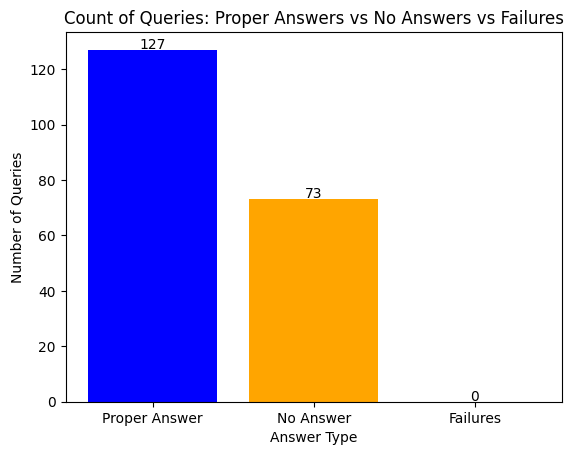

What periodical literature does Delta Air Lines use as a moutpiece?: Success, Answer: ['http://www.wikidata.org/entity/Q3486420']
Who is the child of Ranavalona I's husband?: Success, Answer: ['http://www.wikidata.org/entity/Q218622']
Is it true Jeff_Bridges occupation Lane Chandler and photographer ?: Success, Answer: ['False']
What is the pre-requisite of phase matter of Galinstan?: Success, Answer: ['No answer']
Which is the operating income for Qantas?: Success, Answer: ['1370000000']
which cola starts with the letter p: Success, Answer: ['http://www.wikidata.org/entity/Q100147873', 'Pepsi Perfect', 'http://www.wikidata.org/entity/Q47719', 'Pepsi', 'http://www.wikidata.org/entity/Q18387614', 'Pepsi True', 'http://www.wikidata.org/entity/Q3504021', 'Parsi Cola']
Is the right ascension of malin 1 less than 15.1398?: Success, Answer: ['False']
What is the complete list of records released by Jerry Lee Lewis?: Success, Answer: ['http://www.wikidata.org/entity/Q3029950']
What's Mary Lou

In [44]:
# Define the Skynet Coypu SPARQL endpoint
WIKIDATA_ENDPOINT = "https://skynet.coypu.org/wikidata/"

# Add prefixes once, to avoid repeating this step in each query, this is necessary for the skynet endpoint to work properly
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

def add_prefixes(sparql_query):
    """Add required prefixes to the SPARQL query."""
    return PREFIXES + sparql_query

# querying the SPARQL endpoint using the SPARQLWrapper library, seting the query and returning in JSON
def query_sparql(endpoint, query):
    """Send a SPARQL query to the specified endpoint and return the results."""
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60) # Set timeout to 60 seconds to avoid long waits
    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# handle different types of answers from the SPARQL query results. Furhter check if the answer is a Wikidata link or a literal
def extract_answer(results):
    """Extract the answer from the SPARQL query results, handling boolean answers."""
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    if not bindings:
        return ["No answer"]

    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            if value.startswith("http://www.wikidata.org/entity/"):
                answers.append(value)  # Keep the full Wikidata link
            else:
                answers.append(value)  # Append literals directly
    return answers if answers else ["No answer"]

# Initialize counters for proper/correct answers, no answers, and failures
proper_answer_count = 0
no_answer_count = 0
failure_count = 0

# Lists to hold query results
results = []

# Test the first 200 queries
for entry in lc_quad_data[:200]:
    sparql_query = entry.get('sparql_wikidata')
    question = entry.get('question')
    
    if sparql_query:
        # Add the necessary prefixes to the query
        query_with_prefixes = add_prefixes(sparql_query)
        result = query_sparql(WIKIDATA_ENDPOINT, query_with_prefixes)
        
        if result:
            answer = extract_answer(result)
            if "No answer" in answer:
                no_answer_count += 1
            else:
                proper_answer_count += 1
            results.append((question, 'Success', answer))
        else:
            failure_count += 1
            results.append((question, 'Failure', ['No answer']))

# Print the number of proper answers, no answers, and failures
print(f"Number of queries with proper answers: {proper_answer_count}")
print(f"Number of queries with no answers: {no_answer_count}")
print(f"Number of failed queries: {failure_count}")

# Prepare data for exporting to Excel
df = pd.DataFrame(results, columns=['Question', 'Result', 'Answer'])

# Save results to an Excel file for further inspection
df.to_excel("wikidata_results.xlsx", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [proper_answer_count, no_answer_count, failure_count]

plt.bar(labels, sizes, color=['blue', 'orange', 'red'])
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.5, str(sizes[i]), ha='center')

plt.title('Count of Queries: Proper Answers vs No Answers vs Failures')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.show()

# Optionally print the results for inspection
for question, result, answer in results:
    print(f"{question}: {result}, Answer: {answer}")

## Results wikidata query test with first 200 queries
Most of the queries can be exceuted and return correct results. However there are also so which don't return any answers. After checking those queries manually, for most of them the information is not available anymore, has been updated, changed or the connected entities are not available anymore. 

**template_id: "statement_property_2**: After manually checking the query results, it appears that all queries with the template_id "statement_property_1" & "statement_property_2" are not working. This is due to the fact that the endpoint is not able to execute the queries. The queries are not working in the skynet web interface, however most of them are working in wiki data query service (https://query.wikidata.org/). Those templates are also the ones which include qualifiers, which might be the reason for the failure.

For example: 
When position did Angela Merkel hold on November 10, 1994? (template_id: "statement_property_2"). When executing it in skynet with the following query: 
```
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>

SELECT ?obj WHERE { wd:Q567 p:P39 ?s . ?s ps:P39 ?obj . ?s pq:P580 ?x filter(contains(YEAR(?x),'1994'))}
```

It says: "No data available in table" 

When executing it in wiki data query service:
 
```
SELECT ?obj WHERE { wd:Q567 p:P39 ?s . ?s ps:P39 ?obj . ?s pq:P580 ?x filter(contains(YEAR(?x),'1994'))}
```
It returns the correct answer: 
wd:Q30544097 & wd:Q1939555

## Test for DBpedia endpoint

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"Virtuoso 37000 Error SP030: SPARQL compiler, line 51: syntax error at '<' before 'Domestic'\n\nSPARQL query:\ndefine sql:big-data-const 0\n#output-format:application/sparql-results+json\n\nPREFIX as: <http://www.w3.org/ns/activitystreams#>\nPREFIX bif: <bif:>\nPREFIX dawgt: <http://www.w3.org/2001/sw/DataAccess/tests/test-dawg#>\nPREFIX dbpedia: <http://dbpedia.org/resource/>\nPREFIX dbpprop: <http://dbpedia.org/property/>\nPREFIX dc: <http://purl.org/dc/elements/1.1/>\nPREFIX fn: <http://www.w3.org/2005/xpath-functions/#>\nPREFIX foaf: <http://xmlns.com/foaf/0.1/>\nPREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>\nPREFIX go: <http://purl.org/obo/owl/GO#>\nPREFIX ldp: <http://www.w3.org/ns/ldp#>\nPREFIX math: <http://www.w3.org/2000/10/swap/math#>\nPREFIX mesh: <http://purl.org/commons/record/mesh/>\nPREFIX mf: <http://www.w3.org/2001/sw/DataAccess/t

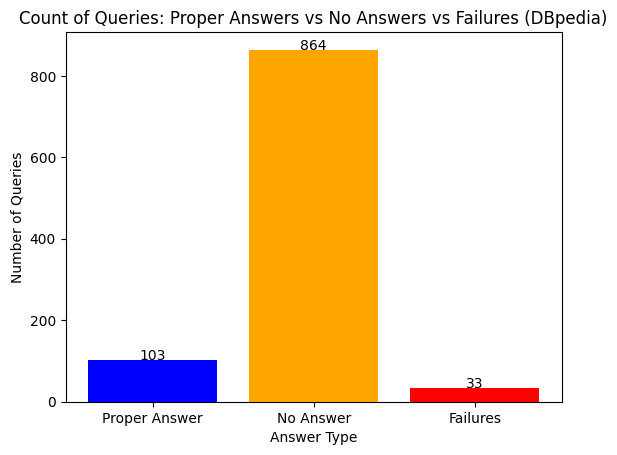

What periodical literature does Delta Air Lines use as a moutpiece?: Success, Answer: ['No answer']
Who is the child of Ranavalona I's husband?: Success, Answer: ['No answer']
Is it true Jeff_Bridges occupation Lane Chandler and photographer ?: Success, Answer: ['False']
What is the pre-requisite of phase matter of Galinstan?: Success, Answer: ['No answer']
Which is the operating income for Qantas?: Success, Answer: ['No answer']
which cola starts with the letter p: Success, Answer: ['No answer']
Is the right ascension of malin 1 less than 15.1398?: Success, Answer: ['False']
What is the complete list of records released by Jerry Lee Lewis?: Success, Answer: ['No answer']
What's Mary Lou Retton's International Olympic Committee athlete ID.: Success, Answer: ['No answer']
Who won the prize at the sequel of the 1885 Wimbledon Championships- Gentlemen's Singles?: Success, Answer: ['No answer']
Is it true that the carbon footprint of the iPhone X Max is 106?: Success, Answer: ['False']
Tel

In [6]:
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON

# Define the DBpedia SPARQL endpoint (assuming your Virtuoso instance is running locally)
DBPEDIA_ENDPOINT = "http://localhost:8897/sparql"

# Add prefixes for DBpedia queries
DBPEDIA_PREFIXES = """
PREFIX as: <http://www.w3.org/ns/activitystreams#>
PREFIX bif: <bif:>
PREFIX dawgt: <http://www.w3.org/2001/sw/DataAccess/tests/test-dawg#>
PREFIX dbpedia: <http://dbpedia.org/resource/>
PREFIX dbpprop: <http://dbpedia.org/property/>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX fn: <http://www.w3.org/2005/xpath-functions/#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.w3.org/2003/01/geo/wgs84_pos#>
PREFIX go: <http://purl.org/obo/owl/GO#>
PREFIX ldp: <http://www.w3.org/ns/ldp#>
PREFIX math: <http://www.w3.org/2000/10/swap/math#>
PREFIX mesh: <http://purl.org/commons/record/mesh/>
PREFIX mf: <http://www.w3.org/2001/sw/DataAccess/tests/test-manifest#>
PREFIX nci: <http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#>
PREFIX obo: <http://www.geneontology.org/formats/oboInOwl#>
PREFIX ogc: <http://www.opengis.net/>
PREFIX ogcgml: <http://www.opengis.net/ont/gml#>
PREFIX ogcgs: <http://www.opengis.net/ont/geosparql#>
PREFIX ogcgsf: <http://www.opengis.net/def/function/geosparql/>
PREFIX ogcgsr: <http://www.opengis.net/def/rule/geosparql/>
PREFIX ogcsf: <http://www.opengis.net/ont/sf#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX product: <http://www.buy.com/rss/module/productV2/>
PREFIX protseq: <http://purl.org/science/protein/bysequence/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfa: <http://www.w3.org/ns/rdfa#>
PREFIX rdfdf: <http://www.openlinksw.com/virtrdf-data-formats#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sc: <http://purl.org/science/owl/sciencecommons/>
PREFIX scovo: <http://purl.org/NET/scovo#>
PREFIX sd: <http://www.w3.org/ns/sparql-service-description#>
PREFIX sioc: <http://rdfs.org/sioc/ns#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
PREFIX sql: <sql:>
PREFIX vcard: <http://www.w3.org/2001/vcard-rdf/3.0#>
PREFIX vcard2006: <http://www.w3.org/2006/vcard/ns#>
PREFIX virtcxml: <http://www.openlinksw.com/schemas/virtcxml#>
PREFIX virtrdf: <http://www.openlinksw.com/schemas/virtrdf#>
PREFIX void: <http://rdfs.org/ns/void#>
PREFIX xf: <http://www.w3.org/2004/07/xpath-functions>
PREFIX xml: <http://www.w3.org/XML/1998/namespace>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX xsl10: <http://www.w3.org/XSL/Transform/1.0>
PREFIX xsl1999: <http://www.w3.org/1999/XSL/Transform>
PREFIX xslwd: <http://www.w3.org/TR/WD-xsl>
PREFIX yago: <http://dbpedia.org/class/yago/>
"""

def add_dbpedia_prefixes(sparql_query):
    """Add required prefixes to the SPARQL query for DBpedia."""
    return DBPEDIA_PREFIXES + sparql_query

# Query the SPARQL endpoint using the SPARQLWrapper library
def query_sparql(endpoint, query):
    """Send a SPARQL query to the specified endpoint and return the results."""
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to 60 seconds to avoid long waits
    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract answers from DBpedia SPARQL results
def extract_answer(results):
    """Extract the answer from the SPARQL query results, handling boolean answers."""
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    if not bindings:
        return ["No answer"]

    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            if value.startswith("http://dbpedia.org/resource/"):
                answers.append(value)  # Keep the full DBpedia link
            else:
                answers.append(value)  # Append literals directly
    return answers if answers else ["No answer"]

# Initialize counters for proper/correct answers, no answers, and failures
proper_answer_count = 0
no_answer_count = 0
failure_count = 0

# Lists to hold query results
results = []

# Test the first 1000 queries for DBpedia
for entry in lc_quad_data[:1000]:
    sparql_query = entry.get('sparql_dbpedia18')  # Use DBpedia-specific queries
    question = entry.get('question')
    
    if sparql_query:
        # Add the necessary prefixes to the query
        query_with_prefixes = add_dbpedia_prefixes(sparql_query)
        result = query_sparql(DBPEDIA_ENDPOINT, query_with_prefixes)
        
        if result:
            answer = extract_answer(result)
            if "No answer" in answer:
                no_answer_count += 1
            else:
                proper_answer_count += 1
            results.append((question, 'Success', answer))
        else:
            failure_count += 1
            results.append((question, 'Failure', ['No answer']))

# Print the number of proper answers, no answers, and failures
print(f"Number of queries with proper answers: {proper_answer_count}")
print(f"Number of queries with no answers: {no_answer_count}")
print(f"Number of failed queries: {failure_count}")

# Prepare data for exporting to Excel
df = pd.DataFrame(results, columns=['Question', 'Result', 'Answer'])

# Save results to an Excel file for further inspection
df.to_excel("dbpedia_results.xlsx", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [proper_answer_count, no_answer_count, failure_count]

plt.bar(labels, sizes, color=['blue', 'orange', 'red'])
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.5, str(sizes[i]), ha='center')

plt.title('Count of Queries: Proper Answers vs No Answers vs Failures (DBpedia)')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.show()

# Optionally print the results for inspection
for question, result, answer in results:
    print(f"{question}: {result}, Answer: {answer}")


In [6]:
def adjust_dbpedia_query(sparql_query):
    """
    Adjusts a query written for 'sparql_dbpedia18' by replacing Wikidata URIs with DBpedia URIs.
    """
    sparql_query = sparql_query.replace("http://wikidata.dbpedia.org/resource/", "http://dbpedia.org/resource/")
    sparql_query = sparql_query.replace("http://www.wikidata.org/entity/", "http://dbpedia.org/ontology/")
    sparql_query = sparql_query.replace("rdf:type", "dbo:type")
    # Add more property-specific replacements as needed
    return sparql_query


In [7]:
DBPEDIA_PREFIXES = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
"""

Query failed: timed out
Query failed: timed out
Query failed: timed out
Number of queries with proper answers: 51
Number of queries with no answers: 240
Number of failed queries: 9


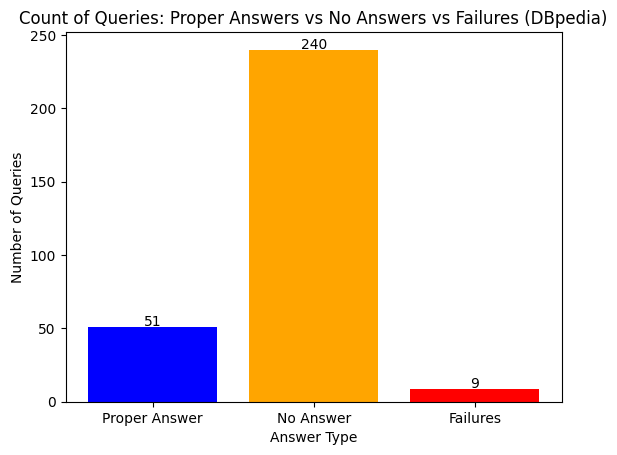

What periodical literature does Delta Air Lines use as a moutpiece?: Success, Answer: ['No answer']
Who is the child of Ranavalona I's husband?: Success, Answer: ['No answer']
Is it true Jeff_Bridges occupation Lane Chandler and photographer ?: Success, Answer: ['False']
What is the pre-requisite of phase matter of Galinstan?: Success, Answer: ['No answer']
Which is the operating income for Qantas?: Success, Answer: ['No answer']
which cola starts with the letter p: Success, Answer: ['No answer']
Is the right ascension of malin 1 less than 15.1398?: Success, Answer: ['False']
What is the complete list of records released by Jerry Lee Lewis?: Success, Answer: ['No answer']
What's Mary Lou Retton's International Olympic Committee athlete ID.: Success, Answer: ['No answer']
Who won the prize at the sequel of the 1885 Wimbledon Championships- Gentlemen's Singles?: Success, Answer: ['No answer']
Is it true that the carbon footprint of the iPhone X Max is 106?: Success, Answer: ['False']
Tel

In [9]:
for entry in lc_quad_data[:100]:
    sparql_query = entry.get('sparql_dbpedia18')  # Use DBpedia-specific queries
    question = entry.get('question')

    if sparql_query:
        # Adjust the query to resolve DBpedia resources and properties
        query_with_prefixes = add_dbpedia_prefixes(adjust_dbpedia_query(sparql_query))
        result = query_sparql(DBPEDIA_ENDPOINT, query_with_prefixes)
        
        if result:
            answer = extract_answer(result)
            if "No answer" in answer:
                no_answer_count += 1
            else:
                proper_answer_count += 1
            results.append((question, 'Success', answer))
        else:
            failure_count += 1
            results.append((question, 'Failure', ['No answer']))
            
# Print the number of proper answers, no answers, and failures
print(f"Number of queries with proper answers: {proper_answer_count}")
print(f"Number of queries with no answers: {no_answer_count}")
print(f"Number of failed queries: {failure_count}")

# Prepare data for exporting to Excel
df = pd.DataFrame(results, columns=['Question', 'Result', 'Answer'])

# Save results to an Excel file for further inspection
df.to_excel("dbpedia_results.xlsx", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [proper_answer_count, no_answer_count, failure_count]

plt.bar(labels, sizes, color=['blue', 'orange', 'red'])
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.5, str(sizes[i]), ha='center')

plt.title('Count of Queries: Proper Answers vs No Answers vs Failures (DBpedia)')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.show()

# Optionally print the results for inspection
for question, result, answer in results:
    print(f"{question}: {result}, Answer: {answer}")



# Test new data source (QALD-9) 
https://github.com/KGQA/QALD_9_plus 

Since the LC-QuAD 2.0 dataset caused two major problems, 
- the first one being that the queries for dbpedia are not working because of the format from dbpedia18 which by that time included wikidata links and 
- the second one being that the wikidata endpoint is not able to execute queries with qualifiers

A new dataset is used to test the wikidata adn DBpedia endpoints. The QALD-9 dataset is used to test the endpoints.

Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"SPARQL-QUERY: queryStr=PREFIX wd: <http://www.wikidata.org/entity/> PREFIX wdt: <http://www.wikidata.org/prop/direct/> PREFIX pq: <http://www.wikidata.org/prop/qualifier/> PREFIX ps: <http://www.wikidata.org/prop/statement/> PREFIX p: <http://www.wikidata.org/prop/>  SELECT ?res WHERE { ?res p:P39 _:a . _:a ps:P39 wd:Q22575092 . :a pq:P580 ?start . } ORDER BY DESC(?start) LIMIT 1\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: com.bigdata.rdf.sail.sparql.ast.VisitorException: QName ':a' uses an undefined prefix\n\tat java.util.concurrent.FutureTask.report(FutureTask.java:122)\n\tat java.util.concurrent.FutureTask.get(FutureTask.java:206)\n\tat com.bigdata.rdf.sail.webapp.BigdataServlet.submitApiTask(BigdataServlet.java:292)\n\tat com.b

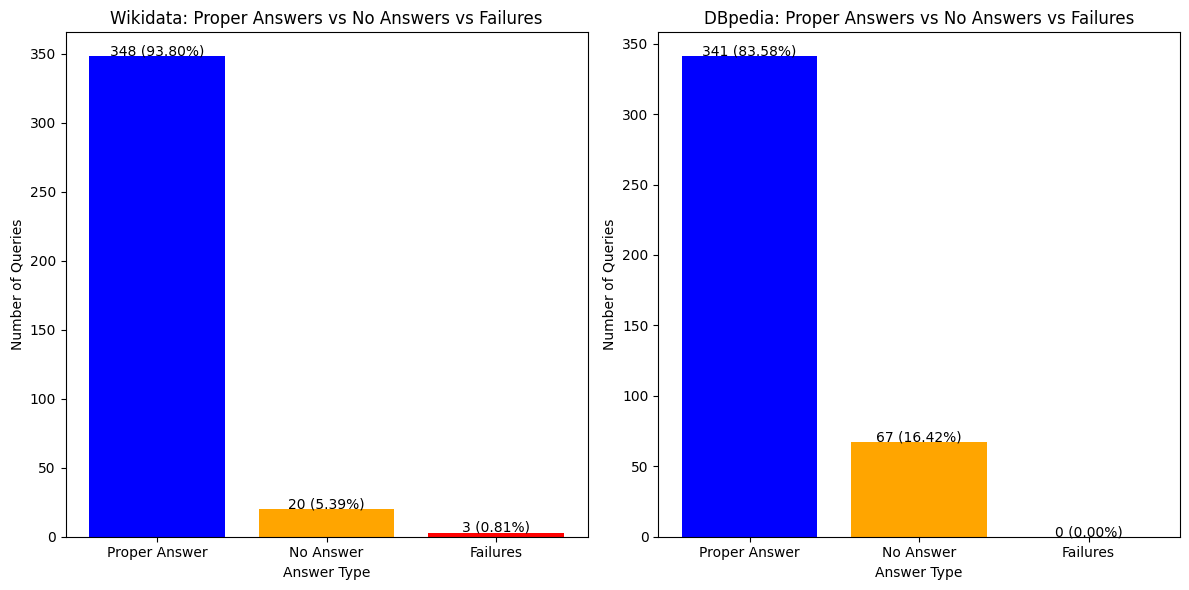

In [11]:
# Load new QALD-9 datasets for Wikidata and DBpedia
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
dbpedia_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_dbpedia.json"

wikidata_data = requests.get(wikidata_url).json()
dbpedia_data = requests.get(dbpedia_url).json()

# Define SPARQL endpoints for Wikidata and DBpedia
WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
DBPEDIA_ENDPOINT = "https://dbpedia.org/sparql"

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare questions from Wikidata and DBpedia datasets
wikidata_questions = extract_questions(wikidata_data, language="en")
dbpedia_questions = extract_questions(dbpedia_data, language="en")

# Initialize counters and results list
wikidata_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
dbpedia_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
wikidata_results = []
dbpedia_results = []

# Function to execute queries and process answers
def process_queries(questions, endpoint, results_list, counts_dict):
    for entry in questions:
        sparql_query = entry.get('sparql')
        question = entry.get('question')
        
        if sparql_query:
            result = query_sparql(endpoint, sparql_query)
            if result:
                answer = extract_answer(result)
                if "No answer" in answer:
                    counts_dict["no_answer"] += 1
                else:
                    counts_dict["proper_answer"] += 1
                results_list.append((question, entry["id"], 'Success', answer))
            else:
                counts_dict["failure"] += 1
                results_list.append((question, entry["id"], 'Failure', ['No answer']))

# Process only first 10 queries for both datasets
process_queries(wikidata_questions, WIKIDATA_ENDPOINT, wikidata_results, wikidata_counts)
process_queries(dbpedia_questions, DBPEDIA_ENDPOINT, dbpedia_results, dbpedia_counts)

# Calculate percentages for each dataset
def calculate_percentages(counts):
    total = counts["proper_answer"] + counts["no_answer"] + counts["failure"]
    proper_answer_pct = (counts["proper_answer"] / total) * 100 if total > 0 else 0
    no_answer_pct = (counts["no_answer"] / total) * 100 if total > 0 else 0
    failure_pct = (counts["failure"] / total) * 100 if total > 0 else 0
    return proper_answer_pct, no_answer_pct, failure_pct

wikidata_proper_pct, wikidata_no_pct, wikidata_failure_pct = calculate_percentages(wikidata_counts)
dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct = calculate_percentages(dbpedia_counts)

# Print counts and percentages
print("Wikidata Results:")
print(f"Proper answers: {wikidata_counts['proper_answer']} ({wikidata_proper_pct:.2f}%)")
print(f"No answers: {wikidata_counts['no_answer']} ({wikidata_no_pct:.2f}%)")
print(f"Failures: {wikidata_counts['failure']} ({wikidata_failure_pct:.2f}%)\n")

print("DBpedia Results:")
print(f"Proper answers: {dbpedia_counts['proper_answer']} ({dbpedia_proper_pct:.2f}%)")
print(f"No answers: {dbpedia_counts['no_answer']} ({dbpedia_no_pct:.2f}%)")
print(f"Failures: {dbpedia_counts['failure']} ({dbpedia_failure_pct:.2f}%)\n")

# Combine results and save to Excel
wikidata_df = pd.DataFrame(wikidata_results, columns=['Question', 'ID', 'Result', 'Answer'])
dbpedia_df = pd.DataFrame(dbpedia_results, columns=['Question', 'ID', 'Result', 'Answer'])

with pd.ExcelWriter("qald9_test_results_split.xlsx") as writer:
    wikidata_df.to_excel(writer, sheet_name="Wikidata Results", index=False)
    dbpedia_df.to_excel(writer, sheet_name="DBpedia Results", index=False)

# Visualize the results with separate bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Wikidata chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [wikidata_counts["proper_answer"], wikidata_counts["no_answer"], wikidata_counts["failure"]]
colors = ['blue', 'orange', 'red']

ax1.bar(labels, sizes, color=colors)
for i in range(len(labels)):
    ax1.text(i, sizes[i] + 0.5, f"{sizes[i]} ({[wikidata_proper_pct, wikidata_no_pct, wikidata_failure_pct][i]:.2f}%)", ha='center')

ax1.set_title('Wikidata: Proper Answers vs No Answers vs Failures')
ax1.set_ylabel('Number of Queries')
ax1.set_xlabel('Answer Type')

# DBpedia chart
sizes = [dbpedia_counts["proper_answer"], dbpedia_counts["no_answer"], dbpedia_counts["failure"]]

ax2.bar(labels, sizes, color=colors)
for i in range(len(labels)):
    ax2.text(i, sizes[i] + 0.5, f"{sizes[i]} ({[dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct][i]:.2f}%)", ha='center')

ax2.set_title('DBpedia: Proper Answers vs No Answers vs Failures')
ax2.set_ylabel('Number of Queries')
ax2.set_xlabel('Answer Type')

plt.tight_layout()
plt.show()

Executing all queries from the QALD-9 dataset with the official endpoints being https://query.wikidata.org/sparql and "https://dbpedia.org/sparql" it can be seen... 

## Check Skynet (Local Wikidata) endpoint
Checking the skynet endpoint to see if the queries are working and if the endpoint is able to return results when hosted locally.

Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'Parse error: Variable used when already in-scope: ?uri in ((AGG ?.0 COUNT(DISTINCT ?uri)) AS ?uri)\n'
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation ti

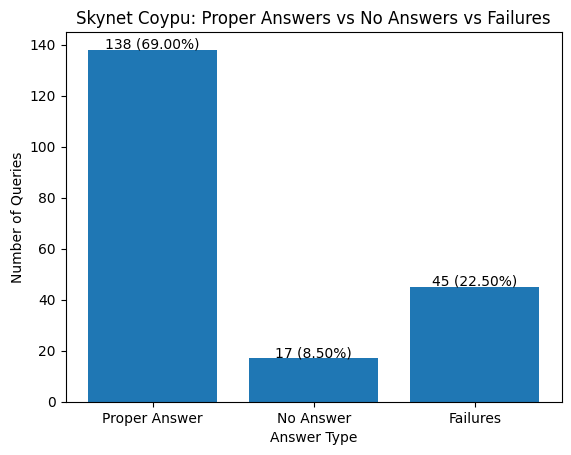

In [ ]:
# Load new QALD-9 datasets for Wikidata
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
wikidata_data = requests.get(wikidata_url).json()

# Define SPARQL endpoints
SKYNET_COYPU_WIKIDATA_ENDPOINT = "https://skynet.coypu.org/wikidata/"

# Define prefixes for the Skynet Coypu endpoint
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

# Function to add prefixes to the SPARQL query
def add_prefixes(sparql_query):
    return PREFIXES + sparql_query

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare questions from Wikidata dataset
wikidata_questions = extract_questions(wikidata_data, language="en")[:200]

# Initialize counters and results list
skynet_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
skynet_results = []

# Function to execute queries with prefixes for Skynet Coypu endpoint
def process_skynet_queries(questions, endpoint, results_list, counts_dict):
    for entry in questions:
        sparql_query = entry.get('sparql')
        question = entry.get('question')
        
        if sparql_query:
            # Add prefixes to the query for Skynet Coypu
            query_with_prefixes = add_prefixes(sparql_query)
            result = query_sparql(endpoint, query_with_prefixes)
            if result:
                answer = extract_answer(result)
                if "No answer" in answer:
                    counts_dict["no_answer"] += 1
                else:
                    counts_dict["proper_answer"] += 1
                results_list.append((question, entry["id"], 'Success', answer))
            else:
                counts_dict["failure"] += 1
                results_list.append((question, entry["id"], 'Failure', ['No answer']))

# Process only first 10 queries for Skynet Coypu
process_skynet_queries(wikidata_questions, SKYNET_COYPU_WIKIDATA_ENDPOINT, skynet_results, skynet_counts)

# Calculate percentages for Skynet Coypu
def calculate_percentages(counts):
    total = counts["proper_answer"] + counts["no_answer"] + counts["failure"]
    proper_answer_pct = (counts["proper_answer"] / total) * 100 if total > 0 else 0
    no_answer_pct = (counts["no_answer"] / total) * 100 if total > 0 else 0
    failure_pct = (counts["failure"] / total) * 100 if total > 0 else 0
    return proper_answer_pct, no_answer_pct, failure_pct

skynet_proper_pct, skynet_no_pct, skynet_failure_pct = calculate_percentages(skynet_counts)

# Print counts and percentages for Skynet Coypu results
print("Skynet Coypu Results:")
print(f"Proper answers: {skynet_counts['proper_answer']} ({skynet_proper_pct:.2f}%)")
print(f"No answers: {skynet_counts['no_answer']} ({skynet_no_pct:.2f}%)")
print(f"Failures: {skynet_counts['failure']} ({skynet_failure_pct:.2f}%)\n")

# Save Skynet results to an Excel file
skynet_df = pd.DataFrame(skynet_results, columns=['Question', 'ID', 'Result', 'Answer'])

with pd.ExcelWriter("skynet_test_results.xlsx") as writer:
    skynet_df.to_excel(writer, sheet_name="Skynet Coypu Results", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [skynet_counts["proper_answer"], skynet_counts["no_answer"], skynet_counts["failure"]]

plt.bar(labels, sizes)
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.5, f"{sizes[i]} ({[skynet_proper_pct, skynet_no_pct, skynet_failure_pct][i]:.2f}%)", ha='center')

plt.title('Skynet Coypu: Proper Answers vs No Answers vs Failures')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.show()


Taking a look at the results from the queries executed with the skynet endpoint https://skynet.coypu.org/wikidata/, it can be seen that most of the queries are working and returning results. However there are significantly more queries which are not working compared to the official wikidata endpoint. Furthermore the runtime is significantly higher taking 55min to execute 200 queries, compared to 7min with the official wikidata endpoint. 

## Check queries with qualifiers only (Wikidata Query Service)
The following check is done to see if the wikidata queries including "qualifiers" are working properly. Since the qulifiers are an important part of wikidata and are one major difference to dbpedia, it is important to see if the queries are working, for the further evaluation and translation of the queries. To check that all queries with qualifiers are executed for poth endpoints.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"SPARQL-QUERY: queryStr=PREFIX wd: <http://www.wikidata.org/entity/> PREFIX wdt: <http://www.wikidata.org/prop/direct/> PREFIX pq: <http://www.wikidata.org/prop/qualifier/> PREFIX ps: <http://www.wikidata.org/prop/statement/> PREFIX p: <http://www.wikidata.org/prop/>  SELECT ?res WHERE { ?res p:P39 _:a . _:a ps:P39 wd:Q22575092 . :a pq:P580 ?start . } ORDER BY DESC(?start) LIMIT 1\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: com.bigdata.rdf.sail.sparql.ast.VisitorException: QName ':a' uses an undefined prefix\n\tat java.util.concurrent.FutureTask.report(FutureTask.java:122)\n\tat java.util.concurrent.FutureTask.get(FutureTask.java:206)\n\tat com.bigdata.rdf.sail.webapp.BigdataServlet.submitApiTask(BigdataServlet.java:292)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doSparqlQuery(QueryServlet.java:678)\n\tat com.big

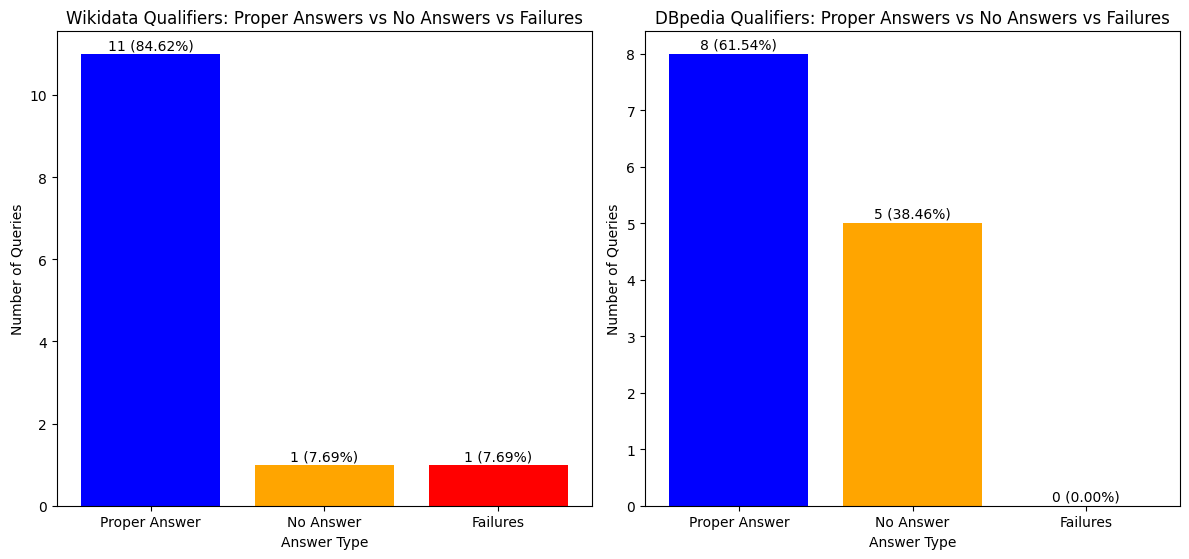

In [13]:
# Load QALD-9 datasets for Wikidata and DBpedia
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
dbpedia_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_dbpedia.json"

wikidata_data = requests.get(wikidata_url).json()
dbpedia_data = requests.get(dbpedia_url).json()

# Define SPARQL endpoints for Wikidata and DBpedia
WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
DBPEDIA_ENDPOINT = "https://dbpedia.org/sparql"

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Extract Wikidata questions with qualifiers and corresponding DBpedia questions
def extract_qualified_questions(wikidata_data, dbpedia_data):
    qualified_wikidata = []
    qualified_dbpedia = []

    # Filter Wikidata questions containing "pq:" in the SPARQL query
    wikidata_qualifiers = [
        q for q in wikidata_data["questions"]
        if "pq:" in q["query"]["sparql"]
    ]

    # Match each Wikidata question with its corresponding DBpedia question using "id"
    for entry in wikidata_qualifiers:
        question_id = entry["id"]
        wikidata_question_data = {
            "id": question_id,
            "question": next((q["string"] for q in entry["question"] if q["language"] == "en"), None),
            "sparql": entry["query"]["sparql"]
        }
        qualified_wikidata.append(wikidata_question_data)

        # Find the matching DBpedia question
        dbpedia_entry = next((q for q in dbpedia_data["questions"] if q["id"] == question_id), None)
        if dbpedia_entry:
            dbpedia_question_data = {
                "id": question_id,
                "question": next((q["string"] for q in dbpedia_entry["question"] if q["language"] == "en"), None),
                "sparql": dbpedia_entry["query"]["sparql"]
            }
            qualified_dbpedia.append(dbpedia_question_data)

    return qualified_wikidata, qualified_dbpedia

# Get qualified questions for both Wikidata and DBpedia
qualified_wikidata, qualified_dbpedia = extract_qualified_questions(wikidata_data, dbpedia_data)

# Initialize counters and results lists
wikidata_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
dbpedia_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
wikidata_results = []
dbpedia_results = []

# Function to execute queries and process answers
def process_queries(questions, endpoint, results_list, counts_dict):
    for entry in questions:
        sparql_query = entry.get('sparql')
        question = entry.get('question')
        
        if sparql_query:
            result = query_sparql(endpoint, sparql_query)
            if result:
                answer = extract_answer(result)
                if "No answer" in answer:
                    counts_dict["no_answer"] += 1
                else:
                    counts_dict["proper_answer"] += 1
                results_list.append((question, entry["id"], 'Success', answer))
            else:
                counts_dict["failure"] += 1
                results_list.append((question, entry["id"], 'Failure', ['No answer']))

# Process qualified queries for both Wikidata and DBpedia
process_queries(qualified_wikidata, WIKIDATA_ENDPOINT, wikidata_results, wikidata_counts)
process_queries(qualified_dbpedia, DBPEDIA_ENDPOINT, dbpedia_results, dbpedia_counts)

# Calculate percentages for each dataset
def calculate_percentages(counts):
    total = counts["proper_answer"] + counts["no_answer"] + counts["failure"]
    proper_answer_pct = (counts["proper_answer"] / total) * 100 if total > 0 else 0
    no_answer_pct = (counts["no_answer"] / total) * 100 if total > 0 else 0
    failure_pct = (counts["failure"] / total) * 100 if total > 0 else 0
    return proper_answer_pct, no_answer_pct, failure_pct

wikidata_proper_pct, wikidata_no_pct, wikidata_failure_pct = calculate_percentages(wikidata_counts)
dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct = calculate_percentages(dbpedia_counts)

# Print counts and percentages
print("Wikidata Results:")
print(f"Proper answers: {wikidata_counts['proper_answer']} ({wikidata_proper_pct:.2f}%)")
print(f"No answers: {wikidata_counts['no_answer']} ({wikidata_no_pct:.2f}%)")
print(f"Failures: {wikidata_counts['failure']} ({wikidata_failure_pct:.2f}%)\n")

print("DBpedia Results:")
print(f"Proper answers: {dbpedia_counts['proper_answer']} ({dbpedia_proper_pct:.2f}%)")
print(f"No answers: {dbpedia_counts['no_answer']} ({dbpedia_no_pct:.2f}%)")
print(f"Failures: {dbpedia_counts['failure']} ({dbpedia_failure_pct:.2f}%)\n")

# Combine results and save to Excel
wikidata_df = pd.DataFrame(wikidata_results, columns=['Question', 'ID', 'Result', 'Answer'])
dbpedia_df = pd.DataFrame(dbpedia_results, columns=['Question', 'ID', 'Result', 'Answer'])

with pd.ExcelWriter("qualifiers_qald9_results.xlsx") as writer:
    wikidata_df.to_excel(writer, sheet_name="Wikidata Results", index=False)
    dbpedia_df.to_excel(writer, sheet_name="DBpedia Results", index=False)

# Visualize the results with separate bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Wikidata chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [wikidata_counts["proper_answer"], wikidata_counts["no_answer"], wikidata_counts["failure"]]

ax1.bar(labels, sizes, color=colors)
for i in range(len(labels)):
    ax1.text(i, sizes[i] + 0.1, f"{sizes[i]} ({[wikidata_proper_pct, wikidata_no_pct, wikidata_failure_pct][i]:.2f}%)", ha='center')

ax1.set_title('Wikidata Qualifiers: Proper Answers vs No Answers vs Failures')
ax1.set_ylabel('Number of Queries')
ax1.set_xlabel('Answer Type')

# DBpedia chart
sizes = [dbpedia_counts["proper_answer"], dbpedia_counts["no_answer"], dbpedia_counts["failure"]]

ax2.bar(labels, sizes, color=colors)
for i in range(len(labels)):
    ax2.text(i, sizes[i] + 0.1, f"{sizes[i]} ({[dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct][i]:.2f}%)", ha='center')

ax2.set_title('DBpedia Qualifiers: Proper Answers vs No Answers vs Failures')
ax2.set_ylabel('Number of Queries')
ax2.set_xlabel('Answer Type')

# Adjust layout to provide more space for the titles
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave extra space at the top for titles
plt.show()


## DBpedia Test for local endpoint
Checking the local dbpedia endpoint hosted on clever to see if the queries are also working locally and if there is a difference in the results compared to the official dbpedia endpoint.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Token \\"COUNT\\": extraneous input \'COUNT\' expecting {\'*\', \'(\', DISTINCT, REDUCED, VAR1, VAR2}",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 7,\n        "query": "SELECT COUNT(DISTINCT ?uri AS ?uri) WHERE { ?uri <http://dbpedia.org/ontology/director> <http://dbpedia.org/resource/Park_Chan-wook> . }",\n        "startIndex": 7,\n        "stopIndex": 11\n    },\n    "query": "SELECT COUNT(DISTINCT ?uri AS ?uri) WHERE { ?uri <http://dbpedia.org/ontology/director> <http://dbpedia.org/resource/Park_Chan-wook> . }",\n    "resultsize": 0,\n    "status": "ERROR",\n    "time": {\n        "computeResult": 0,\n        "total": 0\n    }\n}'
Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid

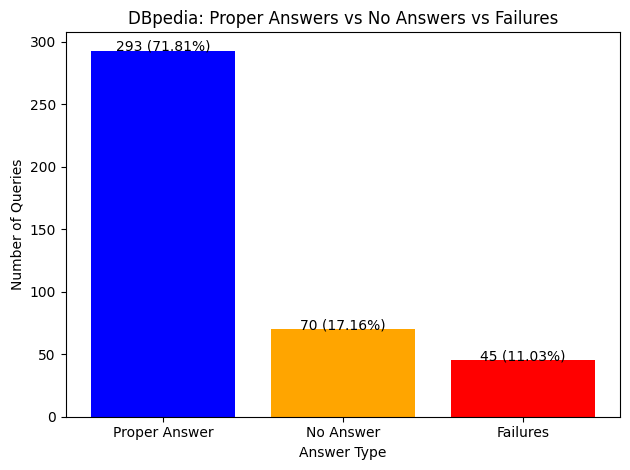

In [10]:
# Load QALD-9 dataset for DBpedia
dbpedia_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_dbpedia.json"
dbpedia_data = requests.get(dbpedia_url).json()

# Define SPARQL endpoint for local DBpedia
DBPEDIA_ENDPOINT = "http://localhost:7012/sparql"  # Local DBpedia endpoint

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare the first 10 questions from DBpedia dataset
dbpedia_questions = extract_questions(dbpedia_data, language="en")

# Initialize counters and results list for DBpedia
dbpedia_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
dbpedia_results = []

# Function to execute queries and process answers
def process_queries(questions, endpoint, results_list, counts_dict):
    for entry in questions:
        sparql_query = entry.get('sparql')
        question = entry.get('question')
        
        if sparql_query:
            result = query_sparql(endpoint, sparql_query)
            if result:
                answer = extract_answer(result)
                if "No answer" in answer:
                    counts_dict["no_answer"] += 1
                else:
                    counts_dict["proper_answer"] += 1
                results_list.append((question, entry["id"], 'Success', answer))
            else:
                counts_dict["failure"] += 1
                results_list.append((question, entry["id"], 'Failure', ['No answer']))

# Process only the first 10 DBpedia queries
process_queries(dbpedia_questions, DBPEDIA_ENDPOINT, dbpedia_results, dbpedia_counts)

# Calculate percentages for DBpedia results
def calculate_percentages(counts):
    total = counts["proper_answer"] + counts["no_answer"] + counts["failure"]
    proper_answer_pct = (counts["proper_answer"] / total) * 100 if total > 0 else 0
    no_answer_pct = (counts["no_answer"] / total) * 100 if total > 0 else 0
    failure_pct = (counts["failure"] / total) * 100 if total > 0 else 0
    return proper_answer_pct, no_answer_pct, failure_pct

dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct = calculate_percentages(dbpedia_counts)

# Print counts and percentages for DBpedia
print("DBpedia Results:")
print(f"Proper answers: {dbpedia_counts['proper_answer']} ({dbpedia_proper_pct:.2f}%)")
print(f"No answers: {dbpedia_counts['no_answer']} ({dbpedia_no_pct:.2f}%)")
print(f"Failures: {dbpedia_counts['failure']} ({dbpedia_failure_pct:.2f}%)\n")

# Save DBpedia results to an Excel file
dbpedia_df = pd.DataFrame(dbpedia_results, columns=['Question', 'ID', 'Result', 'Answer'])

with pd.ExcelWriter("dbpedia_test_results_local.xlsx") as writer:
    dbpedia_df.to_excel(writer, sheet_name="DBpedia Results", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [dbpedia_counts["proper_answer"], dbpedia_counts["no_answer"], dbpedia_counts["failure"]]

plt.bar(labels, sizes, color=colors)
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.1, f"{sizes[i]} ({[dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct][i]:.2f}%)", ha='center')

plt.title('DBpedia: Proper Answers vs No Answers vs Failures')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.tight_layout()
plt.show()


## Building working dataset for Wikidata and DBpedia
After checking the queries from the QALD-9 dataset, it can be seen that the queries are working for both endpoints. Now the goal is to create a new dataset which includes only the queries which are working for both endpoints.

In [ ]:
# Load QALD-9 datasets for Wikidata and DBpedia
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
dbpedia_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_dbpedia.json"

wikidata_data = requests.get(wikidata_url).json()
dbpedia_data = requests.get(dbpedia_url).json()

# Define SPARQL endpoints for Wikidata and local DBpedia
WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
DBPEDIA_ENDPOINT = "http://localhost:7012/sparql"  # Local DBpedia endpoint

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare questions from both Wikidata and DBpedia datasets
wikidata_questions = extract_questions(wikidata_data, language="en")
dbpedia_questions = extract_questions(dbpedia_data, language="en")

# Initialize a list to store questions that work on both endpoints
common_successful_queries = []

# Function to execute queries and check if they return a proper answer
def is_proper_answer(endpoint, sparql_query):
    result = query_sparql(endpoint, sparql_query)
    if result:
        answer = extract_answer(result)
        return "No answer" not in answer  # Return True if it has a proper answer
    return False

# Process and filter questions with proper answers on both Wikidata and DBpedia
for wikidata_entry in wikidata_questions:
    dbpedia_entry = next((q for q in dbpedia_questions if q["id"] == wikidata_entry["id"]), None)
    if dbpedia_entry:
        wikidata_query_success = is_proper_answer(WIKIDATA_ENDPOINT, wikidata_entry["sparql"])
        dbpedia_query_success = is_proper_answer(DBPEDIA_ENDPOINT, dbpedia_entry["sparql"])
        
        if wikidata_query_success and dbpedia_query_success:
            # Store successful queries for both endpoints
            common_successful_queries.append({
                "id": wikidata_entry["id"],
                "question": wikidata_entry["question"],
                "wikidata_sparql": wikidata_entry["sparql"],
                "dbpedia_sparql": dbpedia_entry["sparql"]
            })

# Calculate the percentage of successful queries on both endpoints
total_queries = min(len(wikidata_questions), len(dbpedia_questions))  # Total queries available in both datasets
successful_queries_count = len(common_successful_queries)
success_percentage = (successful_queries_count / total_queries) * 100 if total_queries > 0 else 0

# Create a DataFrame for the common successful queries
successful_queries_df = pd.DataFrame(common_successful_queries)

# Save the successful queries to a new Excel file
successful_queries_df.to_excel("common_successful_queries.xlsx", index=False)

# Print summary
print(f"Total questions in the dataset: {total_queries}")
print(f"Total questions with proper answers on both endpoints: {successful_queries_count}")
print(f"Percentage of successful queries on both endpoints: {success_percentage:.2f}%")

## Test for both local enpoints on wikidata as well as DBpedia

In [3]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt

# Load QALD-9 datasets for Wikidata and DBpedia
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
dbpedia_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_dbpedia.json"

wikidata_data = requests.get(wikidata_url).json()
dbpedia_data = requests.get(dbpedia_url).json()

# Define SPARQL endpoints for local Wikidata and DBpedia
WIKIDATA_ENDPOINT = "http://localhost:7001"  # Local Wikidata endpoint
DBPEDIA_ENDPOINT = "http://localhost:7012"  # Local DBpedia endpoint

# Function to query SPARQL endpoint with User-Agent and handle bytes response
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare questions from both Wikidata and DBpedia datasets
wikidata_questions = extract_questions(wikidata_data, language="en")
dbpedia_questions = extract_questions(dbpedia_data, language="en")

# Initialize a list to store questions that work on both endpoints
common_successful_queries = []

# Function to execute queries and check if they return a proper answer
def is_proper_answer(endpoint, sparql_query):
    result = query_sparql(endpoint, sparql_query)
    if result:
        answer = extract_answer(result)
        return "No answer" not in answer  # Return True if it has a proper answer
    return False

# Process and filter questions with proper answers on both Wikidata and DBpedia
for wikidata_entry in wikidata_questions:
    dbpedia_entry = next((q for q in dbpedia_questions if q["id"] == wikidata_entry["id"]), None)
    if dbpedia_entry:
        wikidata_query_success = is_proper_answer(WIKIDATA_ENDPOINT, wikidata_entry["sparql"])
        dbpedia_query_success = is_proper_answer(DBPEDIA_ENDPOINT, dbpedia_entry["sparql"])
        
        if wikidata_query_success and dbpedia_query_success:
            # Store successful queries for both endpoints
            common_successful_queries.append({
                "id": wikidata_entry["id"],
                "question": wikidata_entry["question"],
                "wikidata_sparql": wikidata_entry["sparql"],
                "dbpedia_sparql": dbpedia_entry["sparql"]
            })

# Calculate the percentage of successful and unsuccessful queries
total_queries = min(len(wikidata_questions), len(dbpedia_questions))  # Total queries available in both datasets
successful_queries_count = len(common_successful_queries)
unsuccessful_queries_count = total_queries - successful_queries_count  # Total minus successful
success_percentage = (successful_queries_count / total_queries) * 100 if total_queries > 0 else 0
unsuccess_percentage = 100 - success_percentage

# Create a DataFrame for the common successful queries
successful_queries_df = pd.DataFrame(common_successful_queries)

# Save the successful queries to a new Excel file
successful_queries_df.to_excel("common_successful_queries_local_endpoints.xlsx", index=False)

# Print summary
print(f"Total questions in the dataset: {total_queries}")
print(f"Total questions with proper answers on both endpoints: {successful_queries_count}")
print(f"Total questions with unsuccessful answers on both endpoints: {unsuccessful_queries_count}")
print(f"Percentage of successful queries on both endpoints: {success_percentage:.2f}%")

# Visualize the results in a bar chart
labels = ['Total Queries', 'Successful Queries', 'Unsuccessful Queries']
sizes = [total_queries, successful_queries_count, unsuccessful_queries_count]
percentages = [100, success_percentage, unsuccess_percentage]
colors = ['grey', 'blue', 'red']

plt.bar(labels, sizes, color=colors)
for i, (size, pct) in enumerate(zip(sizes, percentages)):
    plt.text(i, size + 0.1, f"{size} ({pct:.2f}%)", ha='center')
plt.title('Comparison of Total, Successful, and Unsuccessful Queries on Both Endpoints')
plt.ylabel('Number of Queries')
plt.xlabel('Query Type')
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

#### Create Dataset with the successful queries only 

In [2]:
import json

# Create the new dataset structure with only successful queries
successful_dataset = {
    "questions": [
        {
            "id": entry["id"],
            "question": [{"language": "en", "string": entry["question"]}],
            "query": {
                "sparql_wikidata": entry["wikidata_sparql"],
                "sparql_dbpedia": entry["dbpedia_sparql"]
            }
        }
        for entry in common_successful_queries
    ]
}

# Save to a new JSON file
with open("successful_queries_qald9.json", "w") as json_file:
    json.dump(successful_dataset, json_file, indent=4)

print("New dataset with successful queries saved as 'successful_queries_qald9.json'")


NameError: name 'common_successful_queries' is not defined

## Get Relations between DBpedia and Wikidata via "sameAs"

This script is designed to process SPARQL queries from the QALD-9 dataset, extracting entities and relations from DBpedia and finding their equivalent mappings in Wikidata. It also handles duplicate removal and outputs the results in a structured format for further analysis. Below is a detailed explanation of the purpose and functionality of the code.

---

## **Purpose**

1. **Mapping DBpedia Entities to Wikidata**:
   - The goal is to identify equivalent entities and relations in Wikidata using predefined equivalence properties from DBpedia entries.

2. **Dataset**:
   - The script uses the dataset of 240 successful SPARQL queries (`successful_queries_qald9.json`), which are verified to work on both DBpedia and Wikidata endpoints.

3. **Exclude List**:
   - An exclude list (`exclude_items`) filters out query prefixes in DBpedia that are not directly translatable to Wikidata (e.g., prefixes like `dbo:` or `rdf:type` etc.).

4. **Output**:
   - The results are saved into:
     - `mapped_entities_relations.json`: Contains mappings of DBpedia entities to Wikidata equivalents.
     - `removed_duplicates.json`: Logs duplicate entries for further analysis.

---

## **Code Workflow**

### 1. **Setup**
**Query Template**:
  - A SPARQL query template (`DBPEDIA_EQUIVALENT_QUERY_TEMPLATE`) is used to identify equivalent properties in DBpedia entries which are translatable to other knowledge graphs, such as `owl:sameAs`, `owl:equivalentProperty`, and `owl:equivalentClass`.
  - Only links containing `http://www.wikidata.org/` are retained to exclude relations to other KGs like Geonames or Freebase.

### 2. **Prefix Expansion**
- Function: `expand_prefix(identifier)`: Converts prefixed DBpedia terms (e.g., `dbo:` or `res:`) into full URIs using a predefined mapping (`DBPEDIA_PREFIXES`).

### 3. **Extracting Entities and Relations**
- Function: `extract_entities_relations(query)`: Extracts entities and relations from the `sparql_dbpedia` queries using regular expressions and removes unwanted characters such as `<`, `>`, and trailing `>.`, which are included in the syntax of the DBpedia query.

### 4. **Finding Equivalent Entities in Wikidata**
- Function: `get_wikidata_equivalents(dbpedia_id)`: Queries the DBpedia SPARQL endpoint to find equivalent entities in Wikidata using OWL properties and filters results to include only those pointing to Wikidata URLs.

### 5. **Processing Queries**
For each query in the dataset:
**Entities and Relations Extraction**:
- Entities and relations are extracted and cleaned.
**Equivalence Mapping**:
- For each extracted DBpedia entity, equivalent entities in Wikidata are identified.
**Duplicate Removal**:
- Duplicates are tracked using a `seen_dbpedia_ids` set.
- If a duplicate is detected, it is logged and excluded from the results.
- **Result Structuring**:
Each processed query is structured into a dictionary containing:
- `question_id`: Unique identifier for the query.
- `question`: The natural language question.
- `dbpedia_query`: The original DBpedia SPARQL query.
- `mapped_entities_relations`: Mappings of DBpedia entities to Wikidata equivalents.

In [2]:
# Exclude list with exact matching
exclude_items = {
    "http://dbpedia.org/ontology/", "dbo:", "http://dbpedia.org/resource/", "res:",
    "rdf:", "http://www.w3.org/1999/02/22-rdf-syntax-ns#", "rdf:type",
    "dbr:", "dbp:", "rdfs:", "http://www.w3.org/2000/01/rdf-schema#",
    "http://www.w3.org/1999/02/22-rdf-syntax-ns#type", "http://dbpedia.org/property/",
    "yago:", "http://dbpedia.org/class/yago/", "http://dbpedia.org/ontology/type",
    "onto:", "dbo:type", "skos:", "http://www.w3.org/2004/02/skos/core#",
    "dbc:", "dct:"
}

# Load the dataset
with open("successful_queries_qald9.json", "r") as file:
    dbpedia_data = json.load(file)["questions"]

# SPARQL endpoint for DBpedia
DBPEDIA_ENDPOINT = "http://localhost:7012"  # Local DBpedia endpoint

# SPARQL query template to find equivalent links for a DBpedia entity
DBPEDIA_EQUIVALENT_QUERY_TEMPLATE = """
SELECT ?wikidataEquivalent WHERE {{
    {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#sameAs> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#equivalentProperty> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#equivalentClass> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#sameIndividualAs> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#differentFrom> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#AllDifferent> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#disjointWith> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#inverseOf> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#Ontology> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#Restriction> ?wikidataEquivalent .
    }}
    FILTER STRSTARTS(STR(?wikidataEquivalent), "http://www.wikidata.org/")
}}
"""

# Mapping of prefixes to namespaces
DBPEDIA_PREFIXES = {
    "dbo": "http://dbpedia.org/ontology/",
    "res": "http://dbpedia.org/resource/",
    "yago": "http://dbpedia.org/class/yago/",
    "onto": "http://dbpedia.org/ontology/",
    "dbp": "http://dbpedia.org/property/",
    "dbr": "http://dbpedia.org/resource/",
    "skos": "http://www.w3.org/2004/02/skos/core#",
    "dbc": "http://dbpedia.org/resource/Category:",
    "dct": "http://purl.org/dc/terms/"
}

# Initialize SPARQL wrapper for DBpedia
dbpedia_sparql = SPARQLWrapper(DBPEDIA_ENDPOINT)

def expand_prefix(identifier):
    """
    Expand prefixed entities and relations into full URIs.
    """
    if ":" in identifier:
        prefix, local_name = identifier.split(":", 1)
        if prefix in DBPEDIA_PREFIXES:
            return f"{DBPEDIA_PREFIXES[prefix]}{local_name}"
    return identifier

def extract_entities_relations(query):
    """
    Extract entities and relations from the SPARQL query.
    """
    # Matches full URIs and prefixed entities/relations
    entity_relation_pattern = r"<([^>]+)>|(\w+:[^\s,;]*)"
    matches = re.findall(entity_relation_pattern, query)
    extracted_ids = [match[0] if match[0] else expand_prefix(match[1]) for match in matches]
    print(f"Extracted entities/relations: {extracted_ids}")
    return extracted_ids

def get_wikidata_equivalents(dbpedia_id):
    """
    Query DBpedia for equivalent Wikidata entities.
    """
    wikidata_equivalents = []
    query = DBPEDIA_EQUIVALENT_QUERY_TEMPLATE.format(dbpedia_entity=dbpedia_id)
    dbpedia_sparql.setQuery(query)
    dbpedia_sparql.setReturnFormat(JSON)
    try:
        results = dbpedia_sparql.query().convert()
        equivalents = [
            result["wikidataEquivalent"]["value"]
            for result in results["results"]["bindings"]
        ]
        wikidata_equivalents.extend(equivalents)
    except Exception as e:
        print(f"Error querying for {dbpedia_id}: {e}")
    return list(set(wikidata_equivalents))

# Process the queries
mapped_entities_relations = []
total_duplicates_removed = 0
removed_duplicates = []

for entry in dbpedia_data:
    dbpedia_query = entry["query"]["sparql_dbpedia"]
    extracted_ids = extract_entities_relations(dbpedia_query)

    er2 = {"entities_relations": []}
    seen_dbpedia_ids = set()  # Track unique dbpedia_ids for duplicates

    for dbpedia_id in extracted_ids:
        # Skip if dbpedia_id is in exclude list
        if dbpedia_id in exclude_items:
            continue

        # Retrieve equivalents from DBpedia
        wikidata_ids = get_wikidata_equivalents(dbpedia_id)

        # Check for duplicates
        if dbpedia_id not in seen_dbpedia_ids:
            er2["entities_relations"].append({
                "dbpedia_id": dbpedia_id,
                "wikidata_ids": wikidata_ids
            })
            seen_dbpedia_ids.add(dbpedia_id)
        else:
            total_duplicates_removed += 1
            removed_duplicates.append({
                "question_id": entry["id"],
                "dbpedia_id": dbpedia_id,
                "wikidata_ids": wikidata_ids
            })

    mapped_entities_relations.append({
        "question_id": entry["id"],
        "question": entry["question"][0]["string"],
        "dbpedia_query": dbpedia_query,
        "mapped_entities_relations": er2
    })

# Save the results to a JSON file
with open("mapped_entities_relations.json", "w") as file:
    json.dump(mapped_entities_relations, file, indent=4)

# Save the removed duplicates to a separate file
with open("removed_duplicates.json", "w") as file:
    json.dump(removed_duplicates, file, indent=4)

# Output summary
print("Mappings saved to 'mapped_entities_relations.json'.")
print(f"Total duplicates removed: {total_duplicates_removed}")
print(f"Details of removed duplicates saved to 'removed_duplicates.json'.")


Extracted entities/relations: ['http://dbpedia.org/ontology/', 'http://dbpedia.org/ontology/', 'http://dbpedia.org/resource/', 'http://dbpedia.org/resource/', 'rdfs:', 'http://www.w3.org/2000/01/rdf-schema#', 'http://dbpedia.org/ontology/publisher', 'http://dbpedia.org/resource/GMT_Games']
Extracted entities/relations: ['http://dbpedia.org/ontology/', 'http://dbpedia.org/ontology/', 'http://dbpedia.org/resource/', 'http://dbpedia.org/resource/', 'rdfs:', 'http://www.w3.org/2000/01/rdf-schema#', 'http://dbpedia.org/resource/Skype', 'http://dbpedia.org/ontology/developer']
Extracted entities/relations: ['http://dbpedia.org/class/yago/', 'http://dbpedia.org/class/yago/', 'rdfs:', 'http://www.w3.org/2000/01/rdf-schema#', 'rdf:', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#', 'http://dbpedia.org/ontology/', 'http://dbpedia.org/ontology/', 'rdf:type', 'http://dbpedia.org/ontology/Person', 'http://dbpedia.org/ontology/birthPlace', 'http://dbpedia.org/resource/Heraklion']
Extracted entities/re

## Analysis of the Results
- In general 637 DBpedia entities/relations got detected, while 493 could successfully be mapped to Wikidata, 144 could not be mapped.

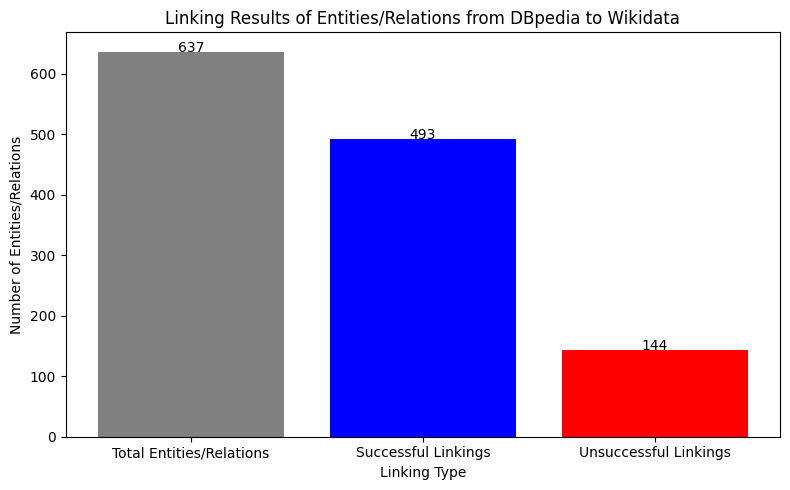

In [3]:
import json
# Load the results from the JSON file (adjust the file path if necessary)
with open("mapped_entities_relations.json", "r") as file:
    mapped_entities_relations = json.load(file)

# Count successful linkings
total_entities_relations = 0
successful_linkings = 0

for entry in mapped_entities_relations:
    for er in entry["mapped_entities_relations"]["entities_relations"]:
        total_entities_relations += 1
        if er["wikidata_ids"]:  # Count if there's at least one valid Wikidata ID
            successful_linkings += 1

# Calculate unsuccessful linkings
unsuccessful_linkings = total_entities_relations - successful_linkings

# Plot the results
labels = ['Total Entities/Relations', 'Successful Linkings', 'Unsuccessful Linkings']
sizes = [total_entities_relations, successful_linkings, unsuccessful_linkings]
colors = ['grey', 'blue', 'red']

plt.figure(figsize=(8, 5))
plt.bar(labels, sizes, color=colors)
for i, size in enumerate(sizes):
    plt.text(i, size + 0.1, f"{size}", ha='center')
plt.title('Linking Results of Entities/Relations from DBpedia to Wikidata')
plt.ylabel('Number of Entities/Relations')
plt.xlabel('Linking Type')
plt.tight_layout()
plt.show()


## Find unsuccessful mappings
In order to find the unsuccessful mappings, the empty mappings are extracted and saved in a separate file. In general there are 112 questions with unmapped entities/relations. There are two possible reasons for the unmapped entities/relations:
- The entities/relations are not present in Wikidata.
- The entities/relations are present in Wikidata but are not linked to the corresponding DBpedia entities/relations.

In order to get the better insights into the empty mappings the 112 questions are checked manuall, to see if the entities/relations are present in Wikidata or not.

In [4]:
import json

# Load the dataset
with open("mapped_entities_relations.json", "r") as file:
    data = json.load(file)

# Collect entries where "wikidata_ids" is empty
unmapped_entries = []

for entry in data:
    unmapped_entities = [
        entity for entity in entry["mapped_entities_relations"]["entities_relations"]
        if not entity["wikidata_ids"]  # Check if "wikidata_ids" is empty
    ]
    if unmapped_entities:  # Only include if there are unmapped entities
        unmapped_entries.append({
            "question_id": entry["question_id"],
            "question": entry["question"],
            "dbpedia_query": entry["dbpedia_query"],
            "unmapped_entities": unmapped_entities
        })

# Save the unmapped entries to a JSON file
with open("unmapped_entities.json", "w") as file:
    json.dump(unmapped_entries, file, indent=4)

print(f"Found {len(unmapped_entries)} questions with unmapped entities.")
print("Results saved to 'unmapped_entities.json'.")

Found 112 questions with unmapped entities.
Results saved to 'unmapped_entities.json'.


In [5]:
# Load the JSON data from the file
with open("unmapped_entities.json", "r") as file:
    json_data = json.load(file)

# Convert JSON data into a pandas DataFrame
data = []
for entry in json_data:
    for entity in entry["unmapped_entities"]:
        data.append({
            "question_id": entry["question_id"],
            "question": entry["question"],
            "dbpedia_query": entry["dbpedia_query"],
            "dbpedia_id": entity["dbpedia_id"],
            "wikidata_ids": ", ".join(entity["wikidata_ids"]) if entity["wikidata_ids"] else ""
        })

df = pd.DataFrame(data)

# Save to an Excel file
df.to_excel("unmapped_entities_output.xlsx", index=False)

print("File saved as 'unmapped_entities_output.xlsx'")


File saved as 'unmapped_entities_output.xlsx'


After manually checking the empty mappings, three further mappings could be found, which were not found by the script. The other 144 mappings are not present in Wikidata.

Thoughts for better mapping: 
- Sometimes property/... does not have a direct mapping to Wikidata, but ontology/... has a mapping. Could this be a solution? 
- Give more hints for the mapping, when there is no direct mapping, e.g. give more of the information which is provided in the DBpedia entry, e.g. rdfs lables (domain, label, range, ...)


## Analyis of frequency in mapped entities and relations
In the following the frequency of the mapped entities and relations is analyzed, highlighting the most frequently linked entities. The results are used to understand patterns in entity mapping and provide a summary of `dbpedia_id` usage, and make them comparable to extraction from the original dataset (later in this scriped). In total there are 393 unique entities, while the entities "starring" and "country" appear most frequently, with 17 mappings each.


In [6]:
# Load the JSON dataset
with open("mapped_entities_relations.json", "r") as file:
    mapped_entities_relations = json.load(file)

# Counter for dbpedia_id occurrences
dbpedia_id_counter = Counter()

# Process each entry in the dataset
for entry in mapped_entities_relations:
    entities_relations = entry["mapped_entities_relations"]["entities_relations"]
    for entity_relation in entities_relations:
        dbpedia_id = entity_relation["dbpedia_id"]
        dbpedia_id_counter[dbpedia_id] += 1

# Calculate the total count
total_count = sum(dbpedia_id_counter.values())

# Sort by occurrences in descending order
sorted_dbpedia_ids = sorted(dbpedia_id_counter.items(), key=lambda x: x[1], reverse=True)

# Output the results
print(f"Total unique dbpedia_id entries: {len(dbpedia_id_counter)}")
print(f"Total occurrences of all dbpedia_id entries: {total_count}")
print("Unique dbpedia_id entries with their counts (sorted by count, descending):")
for dbpedia_id, count in sorted_dbpedia_ids:
    print(f"{dbpedia_id}: {count}")

# Save the results to a JSON file
output_data = {
    "unique_count": len(dbpedia_id_counter),
    "total_count": total_count,
    "dbpedia_ids": dict(sorted_dbpedia_ids)
}

with open("dbpedia_id_summary.json", "w") as file:
    json.dump(output_data, file, indent=4)

print("Results saved to 'dbpedia_id_summary.json'.")


Total unique dbpedia_id entries: 393
Total occurrences of all dbpedia_id entries: 637
Unique dbpedia_id entries with their counts (sorted by count, descending):
http://dbpedia.org/ontology/starring: 17
http://dbpedia.org/ontology/country: 17
http://dbpedia.org/ontology/Film: 15
http://dbpedia.org/ontology/location: 14
http://dbpedia.org/ontology/birthPlace: 10
http://dbpedia.org/ontology/populationTotal: 9
http://dbpedia.org/ontology/author: 8
http://dbpedia.org/ontology/director: 7
http://dbpedia.org/ontology/elevation: 7
http://dbpedia.org/ontology/creator: 6
http://dbpedia.org/resource/Australia: 6
http://dbpedia.org/ontology/Country: 6
http://dbpedia.org/ontology/deathPlace: 5
http://dbpedia.org/ontology/height: 5
http://dbpedia.org/ontology/producer: 5
http://dbpedia.org/ontology/Company: 5
http://dbpedia.org/ontology/currency: 5
http://dbpedia.org/ontology/Mountain: 5
http://dbpedia.org/ontology/developer: 4
http://dbpedia.org/ontology/Person: 4
http://dbpedia.org/ontology/occupa

### Count entities and relations in dbpedia (counted from the original dataset, which includes both dbpedia and wikidata queries) to check how many entities could be translated to wikidata
For Validation and Varification of the results, with the following methods the entities and relations are directly extracted from the 'successful_queries_qald9.json' dataset, without trying to map to wikidata. By comparing the two independent methods, to extract the entities and relations, the extraction can be cross-verified. If both methods include the same entities, it increases confidence in the results. Discrepancies between the results between the two methods can highlight potential errors, allowing to identify issues that otherwise might have been overlooked.

In [7]:
# Function to clean extracted entities and relations
def clean_entity_or_relation(entity):
    """
    Cleans extracted entity or relation:
    - Removes trailing characters like ">."
    - Removes enclosing angle brackets "<>"
    """
    entity = entity.strip("<>")  # Remove enclosing angle brackets
    entity = re.sub(r">\.*$", "", entity)  # Remove trailing ">" or ">."
    return entity

# Function to extract entities and relations from SPARQL queries
def extract_entities_and_relations(sparql_query):
    """
    Extract entities and relations from SPARQL query by cleaning and filtering them.
    """
    # Split into lines
    lines = sparql_query.split("\n")

    # Separate the query body from the PREFIX section
    prefix_end_index = 0
    for i, line in enumerate(lines):
        if not line.strip().startswith("PREFIX"):
            prefix_end_index = i
            break

    query_body = "\n".join(lines[prefix_end_index:])

    # Extract meaningful entities and relations
    operators = {"SELECT", "DISTINCT", "WHERE", "FILTER", "OPTIONAL", "{", "}", ".", ";"}
    query_parts = query_body.replace("\n", " ").split()

    # Include entities, relations, and URLs, applying cleaning
    entities_relations = {
        clean_entity_or_relation(part)
        for part in query_parts
        if not part.upper() in operators and (":" in part or part.startswith("http://"))
    }

    # Filter out items in the exclude list
    filtered_entities_relations = {
        entity for entity in entities_relations if entity not in exclude_items
    }

    return filtered_entities_relations

# Function to transform extracted entities/relations using prefix mappings
def transform_entities_relations(entities_relations):
    """
    Transform entities/relations by applying prefix mappings and keep only the unique URLs.
    """
    unique_urls = set()

    for entity in entities_relations:
        # If the entity is already a URL, add it directly
        if "http://" in entity:
            unique_urls.add(entity)
            continue

        # Check if the entity starts with a known prefix and transform it
        for prefix, url in DBPEDIA_PREFIXES.items():
            if entity.startswith(prefix + ":"):
                # Replace the prefix with the full URL and add it
                transformed_entity = entity.replace(prefix + ":", url)
                unique_urls.add(transformed_entity)
                break

    return unique_urls

# Load the dataset
with open("successful_queries_qald9.json", "r") as file:
    successful_queries = json.load(file)["questions"]

# Process each query and extract entities and relations
all_entities_relations = set()
for entry in successful_queries:
    sparql_dbpedia = entry["query"]["sparql_dbpedia"]
    extracted = extract_entities_and_relations(sparql_dbpedia)
    all_entities_relations.update(extracted)

# Transform the entities and relations
transformed_entities_relations = transform_entities_relations(all_entities_relations)

# Update the JSON structure
output_data = {
    "entities_relations": list(transformed_entities_relations),
}

# Save the updated dataset
with open("transformed_entities_relations_summary.json", "w") as file:
    json.dump(output_data, file, indent=4)

print("Transformed entries saved to 'transformed_entities_relations_summary.json'.")
print(f"Unique entities and relations: {len(transformed_entities_relations)}")

Transformed entries saved to 'transformed_entities_relations_summary.json'.
Unique entities and relations: 393


### Compare both sets and see if both extraction methods show the same results 
Checking the results from the two extraction methods, it can be seen that the results are the same. This means that the extraction methods are working properly and the results can be trusted.

In [8]:
# Load the two datasets
with open("dbpedia_id_summary.json", "r") as file:
    dbpedia_id_summary = json.load(file)

with open("transformed_entities_relations_summary.json", "r") as file:
    entities_relations_summary = json.load(file)

# Extract keys (entries) from both datasets
dbpedia_ids = set(dbpedia_id_summary["dbpedia_ids"].keys())
entities_relations = set(entities_relations_summary["entities_relations"])

# Find entries in dbpedia_ids not present in entities_relations
missing_in_transformed = dbpedia_ids - entities_relations

# Find entries in entities_relations not present in dbpedia_ids
missing_in_dbpedia = entities_relations - dbpedia_ids

# Output the results
print(f"Total entries in dbpedia_id_summary.json: {len(dbpedia_ids)}")
print(f"Total entries in transformed_entities_relations_summary.json: {len(entities_relations)}")
print(f"Entries in dbpedia_id_summary.json not in transformed_entities_relations_summary.json: {len(missing_in_transformed)}")
print(f"Entries in transformed_entities_relations_summary.json not in dbpedia_id_summary.json: {len(missing_in_dbpedia)}")

print("\nEntries in dbpedia_id_summary.json not in transformed_entities_relations_summary.json:")
for entry in missing_in_transformed:
    print(entry)

print("\nEntries in transformed_entities_relations_summary.json not in dbpedia_id_summary.json:")
for entry in missing_in_dbpedia:
    print(entry)

# Save the results to JSON files
# comparison_results = {
#     "missing_in_transformed": list(missing_in_transformed),
#     "missing_in_dbpedia": list(missing_in_dbpedia)
# }

# with open("comparison_results.json", "w") as file:
#     json.dump(comparison_results, file, indent=4)

# print("Comparison results saved to 'comparison_results.json'.")

Total entries in dbpedia_id_summary.json: 393
Total entries in transformed_entities_relations_summary.json: 393
Entries in dbpedia_id_summary.json not in transformed_entities_relations_summary.json: 0
Entries in transformed_entities_relations_summary.json not in dbpedia_id_summary.json: 0

Entries in dbpedia_id_summary.json not in transformed_entities_relations_summary.json:

Entries in transformed_entities_relations_summary.json not in dbpedia_id_summary.json:


## Select 100 mapped queries
In order to create a new dataset with the mapped queries, 100 completely mapped queries are selected. The queries are saved in a new json file, which will lateder be used as input to the LLMs for query translations.

In [9]:
import json
import random

# Load the dataset
with open("mapped_entities_relations.json", "r") as file:
    data = json.load(file)

# Filter for complete entries where all wikidata_ids are non-empty
complete_entries = [
    entry
    for entry in data
    if all(er["wikidata_ids"] for er in entry["mapped_entities_relations"]["entities_relations"])
]

# Check if there are enough entries to select
if len(complete_entries) < 100:
    print(f"Only {len(complete_entries)} complete entries are available. Selecting all.")
    selected_entries = complete_entries
else:
    # Randomly select 100 entries
    selected_entries = random.sample(complete_entries, 100)

# Save the selected entries to a new JSON file
with open("100_complete_entries.json", "w") as file:
    json.dump(selected_entries, file, indent=4)

print(f"Selected {len(selected_entries)} complete entries and saved to '100_complete_entries.json'.")


Selected 100 complete entries and saved to '100_complete_entries.json'.


Create dataset for asking the LLMs

In [ ]:
import json

# Load the dataset from 100_complete_entries.json
with open("100_complete_entries.json", "r") as file:
    data = json.load(file)

# Create input dataset for the LLM
llm_inputs = []

for entry in data:
    # Extract required fields
    question = entry.get("question", "")  # Natural language question
    dbpedia_query = entry.get("dbpedia_query", "")  # SPARQL query for DBpedia
    
    # Extract entities and relations (ER2) in Wikidata
    er2 = [
        {
            "dbpedia_id": er["dbpedia_id"],
            "wikidata_ids": er["wikidata_ids"]
        }
        for er in entry.get("mapped_entities_relations", {}).get("entities_relations", [])
        if er["wikidata_ids"]  # Only include non-empty Wikidata mappings
    ]
    
    # Skip if there are no valid Wikidata mappings
    if not er2:
        continue

    # Construct the input for the LLM
    llm_input = {
        "context": {
            "natural_language_question": question,
            "sparql_query_kg1": dbpedia_query,
            "kg1_name": "DBpedia",
            "kg2_name": "Wikidata",
            "er2": er2,
            "instruction": "Given the information above, produce a SPARQL query for KG2."
        }
    }
    llm_inputs.append(llm_input)

# Save the processed dataset to a new JSON file
with open("llm_input_dataset.json", "w") as file:
    json.dump(llm_inputs, file, indent=4)

print(f"Processed dataset saved to 'llm_input_dataset.json'.")

Processed dataset saved to 'llm_input_dataset.json'.


In [16]:
pip install openai

   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   --------------------- ------------------ 1.0/2.0 MB 5.5 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 5.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
from openai import OpenAI
api_key = '0e18102475c8460f5469f8c98b0a9390' # Replace with your API key
base_url = "https://chat-ai.academiccloud.de/v1"
model = "meta-llama-3.1-8b-instruct" # Choose any available model

# Start OpenAI client
client = OpenAI(
    api_key = api_key,
    base_url = base_url
)

# Get response
chat_completion = client.chat.completions.create(
        messages=[{"role":"system","content":"You are a helpful assistant"},{"role":"user","content":"How tall is the Eiffel tower?"}],
        model= model,
    )

# Print full response as JSON
print(chat_completion) # You can extract the response text from the JSON object

ChatCompletion(id='chat-c27bfd6c742a4c949eef131bb6a59312', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The Eiffel Tower stands at a height of 324 meters (1,063 feet).', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[]), stop_reason=None)], created=1732559119, model='meta-llama-3.1-8b-instruct', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=20, prompt_tokens=29, total_tokens=49, completion_tokens_details=None, prompt_tokens_details=None))
